### 기본 패키지 가져오기

In [9]:
import torch
import random
import numpy as np
import os
import datetime

### wandb 로그인

In [1]:
# 먼저 콘솔창에서 wandb설치
# pip install wandb 

# 그 다음 다음 이 주피터 노트북에서 다음 코드를 실행. 
# wandb.login()
# https://wandb.ai/authorize 여기 로그인하고 API 키 기입

import wandb

# https://wandb.ai/signup # 여기서 runnig 과정 및 결과 확인 가능

### 내 커스텀 패키지 가져오기

In [11]:
import modules

seed 설정

In [12]:
def seed_assign(seed):
    random.seed(seed)                          # Python random 시드 고정
    np.random.seed(seed)                       # NumPy 시드 고정
    torch.manual_seed(seed)                    # PyTorch CPU 시드 고정
    torch.cuda.manual_seed(seed)               # PyTorch GPU 시드 고정
    torch.cuda.manual_seed_all(seed)           # PyTorch 멀티 GPU 시드 고정
    torch.backends.cudnn.deterministic = True  # 연산의 결정론적 동작 보장
    # torch.backends.cudnn.benchmark = False     # 성능 최적화 비활성화 (결정론적 보장)


snn network 만들기

In [13]:
class SNN(torch.nn.Module):
    def __init__(self, v_decay, v_threshold, v_reset_mode, sg_width, surrogate, CLASS_NUM, in_channels, IMAGE_SIZE, time_step):
        super(SNN, self).__init__()
        self.TIME = time_step

        self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding=1)
        IMAGE_SIZE = (IMAGE_SIZE + 2 - 3 // 1) + 1

        self.lif1 = modules.neuron.LIF_layer(v_decay, v_threshold, v_reset_mode, sg_width, surrogate)

        self.fc1 = torch.nn.Linear(32 * IMAGE_SIZE * IMAGE_SIZE, CLASS_NUM)

        self.lif2 = modules.neuron.LIF_layer(v_decay, v_threshold, v_reset_mode, sg_width, surrogate)

    def forward(self, x):
        # SHAPE : [Batch, Time_step, Channel, H, W]

        x = torch.transpose(x, 0, 1)
        # SHAPE : [Time_step, Batch, Channel, H, W]

        T, B, *spatial_dims = x.shape
        x = x.reshape(T * B, *spatial_dims)
        # SHAPE : [Time_step * Batch, Channel, H, W]

        x = self.conv1(x)
        # SHAPE : [Time_step * Batch, Channel, H, W]

        TB, *spatial_dims = x.shape
        x = x.reshape(self.TIME , TB // self.TIME, *spatial_dims)
        # SHAPE : [Time_step, Batch, Channel, H, W]

        x = self.lif1(x)
        # SHAPE : [Time_step, Batch, Channel, H, W]
        
        T, B, *spatial_dims = x.shape
        x = x.reshape(T * B, *spatial_dims)
        # SHAPE : [Time_step * Batch, Channel, H, W]

        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        # SHAPE : [Time_step * Batch, CLASS_NUM]

        TB, *spatial_dims = x.shape
        x = x.reshape(self.TIME , TB // self.TIME, *spatial_dims)
        # SHAPE : [Time_step, Batch, CLASS_NUM]

        x = self.lif2(x)
        # SHAPE : [Time_step, Batch, CLASS_NUM]

        x = x.sum(dim=0)
        # SHAPE : [Batch, CLASS_NUM]

        return x

main 함수

In [14]:
def snn_system(seed,
                which_data,
                batch_size,
                data_path,
                learning_rate,
                time_step,
                v_decay,
                v_threshold,
                v_reset_mode,
                sg_width,
                surrogate,
                max_epoch,
                gpu,
                current_time):
    seed_assign(seed)
    hyperparameters = locals()
    print('hyperparameters', hyperparameters)
    
    wandb.config.update(hyperparameters) # wandb에 모든 하이퍼파라미터 업로드
    wandb.run.name = f'{current_time}' # wandb run name 설정
    # wandb.define_metric("validation_accuracy", summary="max")

    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= gpu

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader, CLASS_NUM, in_channels, IMAGE_SIZE = modules.data_loader.data_loader(which_data, data_path, batch_size)
    net = SNN(v_decay=v_decay, v_threshold=v_threshold, v_reset_mode=v_reset_mode, sg_width=sg_width, surrogate=surrogate, CLASS_NUM=CLASS_NUM, in_channels=in_channels, IMAGE_SIZE=IMAGE_SIZE, time_step=time_step)
    net = net.to(device)

    wandb.watch(net, log="all", log_freq = 10) # 모델을 wandb에 로깅

    criterion = torch.nn.CrossEntropyLoss().to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    # optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    best_validation_accuracy = 0.0
    for epoch in range(max_epoch):
        print(f'Epoch-{epoch}')
        net.train()
        correct_train = 0
        total_train = 0
        train_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            images = images.unsqueeze(1).repeat(1, time_step, 1, 1, 1)  # repeat 코딩. rate코딩 등을 실험해봐도 좋다. # (batch, time_step, C, H, W)
            
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            train_loss += loss.item()

        training_accuracy = 100 * correct_train / total_train
        avg_train_loss = train_loss / len(train_loader)
        print(f'Training_loss: {avg_train_loss:.4f}, Training_accuracy: {training_accuracy:.2f} %')

        # Validation
        net.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                images = images.unsqueeze(1).repeat(1, time_step, 1, 1, 1)  # repeat 코딩. rate코딩 등 실험해봐도 좋다. # (batch, time_step, C, H, W)

                outputs = net(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        validation_accuracy = 100 * correct / total
        avg_val_loss = val_loss / len(test_loader)
        best_validation_accuracy = max(best_validation_accuracy, validation_accuracy)
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f} %, Best Validation Accuracy: {best_validation_accuracy:.2f} %')
        print()
        wandb.log({"avg_train_loss": avg_train_loss})
        wandb.log({"training_accuracy": training_accuracy})
        wandb.log({"avg_val_loss": avg_val_loss})
        wandb.log({"validation_accuracy": validation_accuracy})
        wandb.log({"best_validation_accuracy": best_validation_accuracy})



main 함수 돌리기

In [15]:
seed = 42
which_data = 'MNIST'
batch_size = 64
data_path = '/data2' # <-- 데이터셋 경로 nfs로 지정하면 안됩니다. 무슨 말인지 잘 모르겠으면 문의해주세요.
learning_rate = 0.001
time_step = 10
v_decay = 0.5
v_threshold = 0.5
v_reset_mode = 'soft_reset' # 'soft_reset' or 'hard_reset'
sg_width = 4.0 # surrogate gradient width
surrogate = 'sigmoid' # 'sigmoid' or 'rectangle' or 'rough_rectangle' or 'hard_sigmoid'
max_epoch = 20
gpu = '0' # 사용할 GPU 번호
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}" # 그냥 현재 시각 (마이크로초까지)


wandb.init(project= f'wandb_tutorial',save_code=False) # project name 지정 # save_code =True로 하면 wandb서버에 코드가 저장되는데, wandb서버 용량 잡아먹음. 꼭 필요하면 쓰면 됨. 특정 경로의 코드만 저장하게 할 수도 있음. 관련 정보 구글링 권장.

snn_system(seed=seed,
            which_data=which_data,
            batch_size=batch_size,
            data_path=data_path,
            learning_rate=learning_rate,
            time_step=time_step,
            v_decay=v_decay,
            v_threshold=v_threshold,
            v_reset_mode=v_reset_mode,
            sg_width=sg_width,
            surrogate=surrogate,
            max_epoch=max_epoch,
            gpu=gpu,
            current_time=current_time)

hyperparameters {'seed': 42, 'which_data': 'MNIST', 'batch_size': 64, 'data_path': '/data2', 'learning_rate': 0.001, 'time_step': 10, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset_mode': 'soft_reset', 'sg_width': 4.0, 'surrogate': 'sigmoid', 'max_epoch': 20, 'gpu': '0', 'current_time': '20250317_122435_680'}
Epoch-0
Training_loss: 4.3529, Training_accuracy: 22.15 %
Validation Loss: 4.0000, Validation Accuracy: 29.93 %, Best Validation Accuracy: 29.93 %

Epoch-1
Training_loss: 1.6688, Training_accuracy: 60.65 %
Validation Loss: 0.6147, Validation Accuracy: 77.26 %, Best Validation Accuracy: 77.26 %

Epoch-2
Training_loss: 0.4994, Training_accuracy: 81.33 %
Validation Loss: 0.3437, Validation Accuracy: 87.37 %, Best Validation Accuracy: 87.37 %

Epoch-3
Training_loss: 0.3274, Training_accuracy: 87.73 %
Validation Loss: 0.3358, Validation Accuracy: 87.55 %, Best Validation Accuracy: 87.55 %

Epoch-4
Training_loss: 0.2991, Training_accuracy: 88.39 %
Validation Loss: 0.3212, Validation Accur

In [16]:
wandb.finish() 

avg_train_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_validation_accuracy,▁▆▇▇▇▇▇▇▇▇▇▇████████
training_accuracy,▁▄▆▇▇▇▇▇▇▇▇▇████████
validation_accuracy,▁▆▇▇▇▇▇▇▇▇▇▇████████
avg_train_loss,0.01705
avg_val_loss,0.09019
best_validation_accuracy,97.75
training_accuracy,99.46333
validation_accuracy,97.75


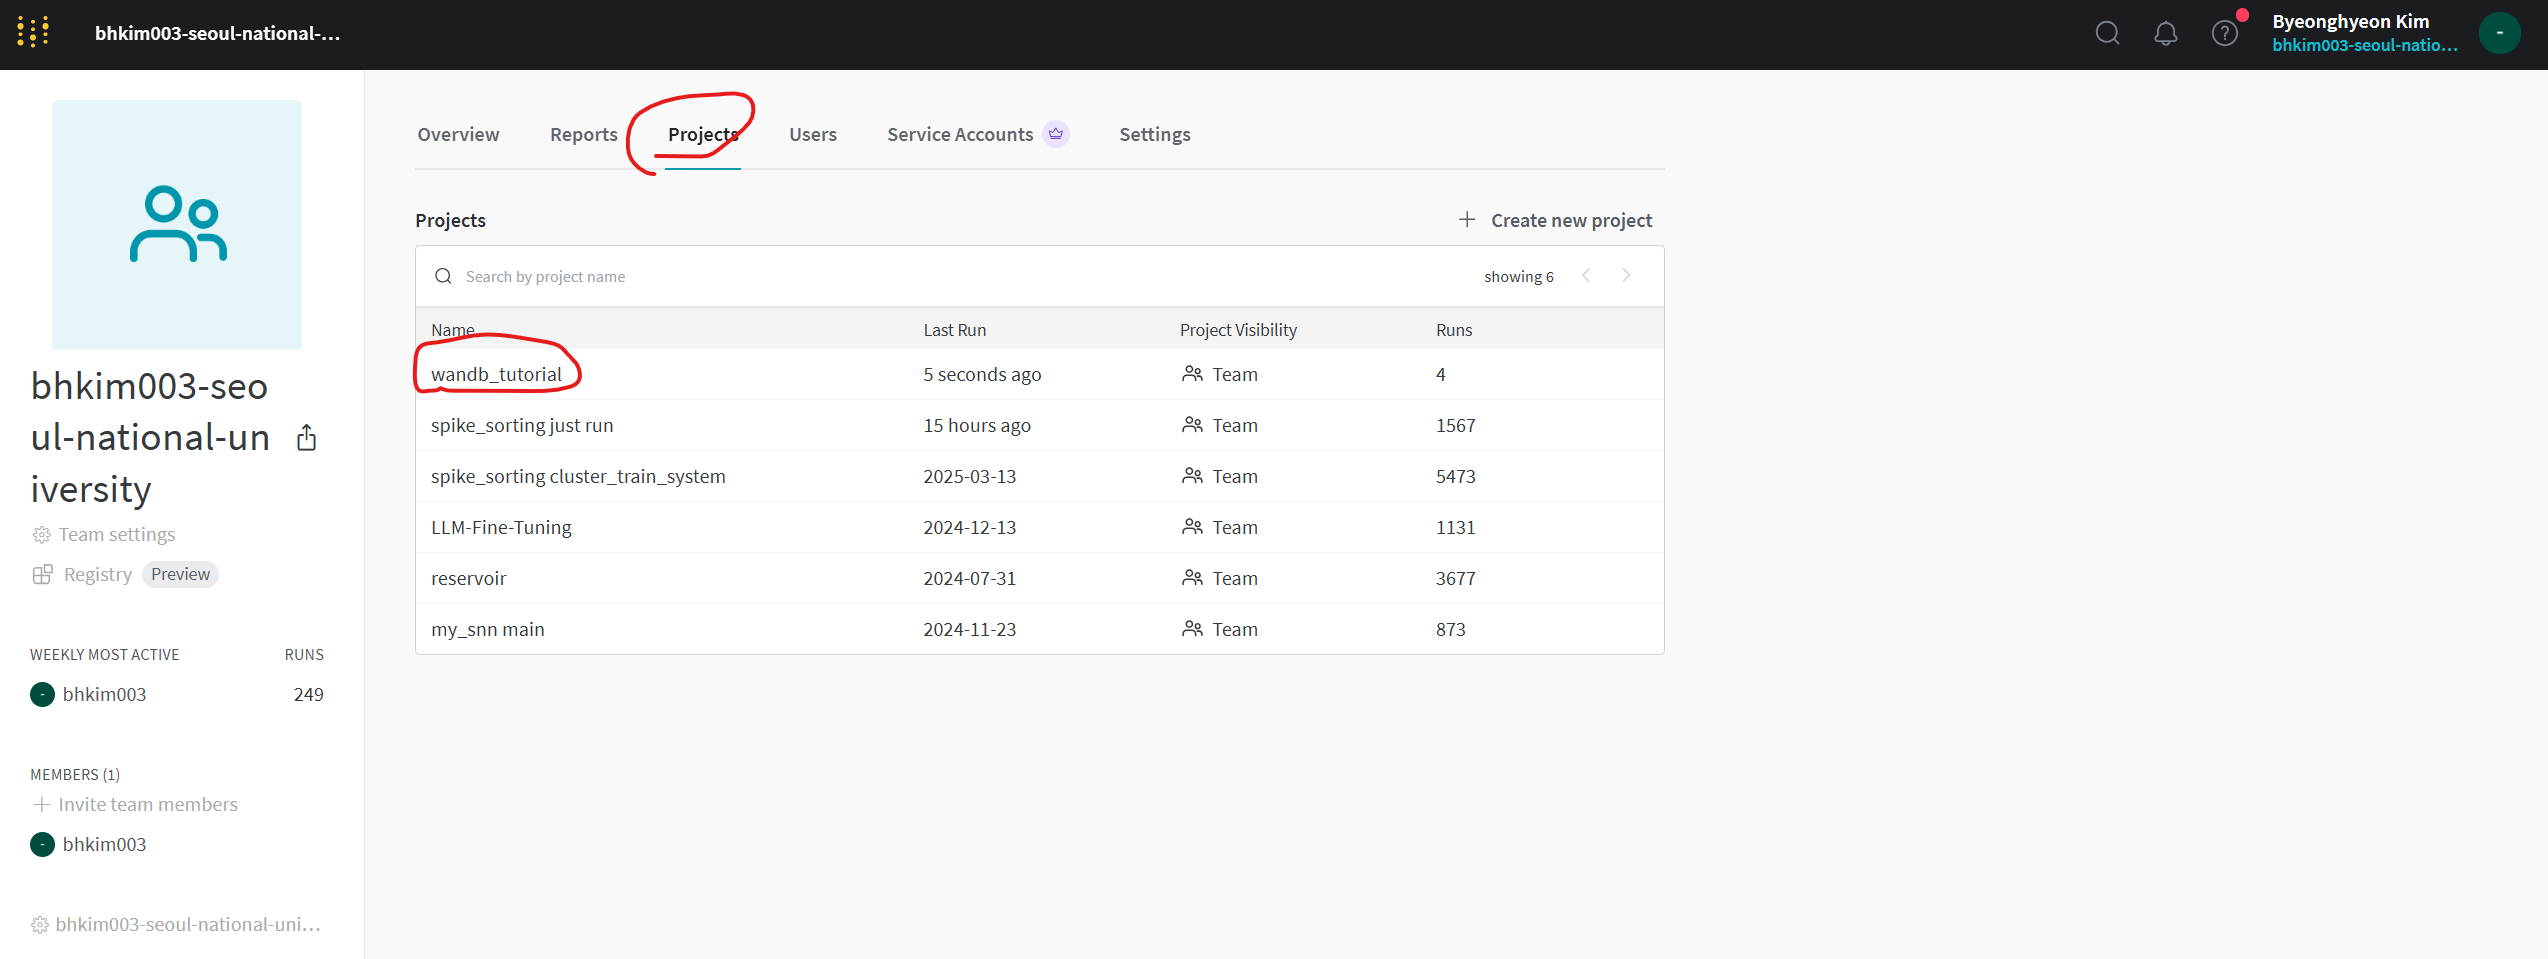

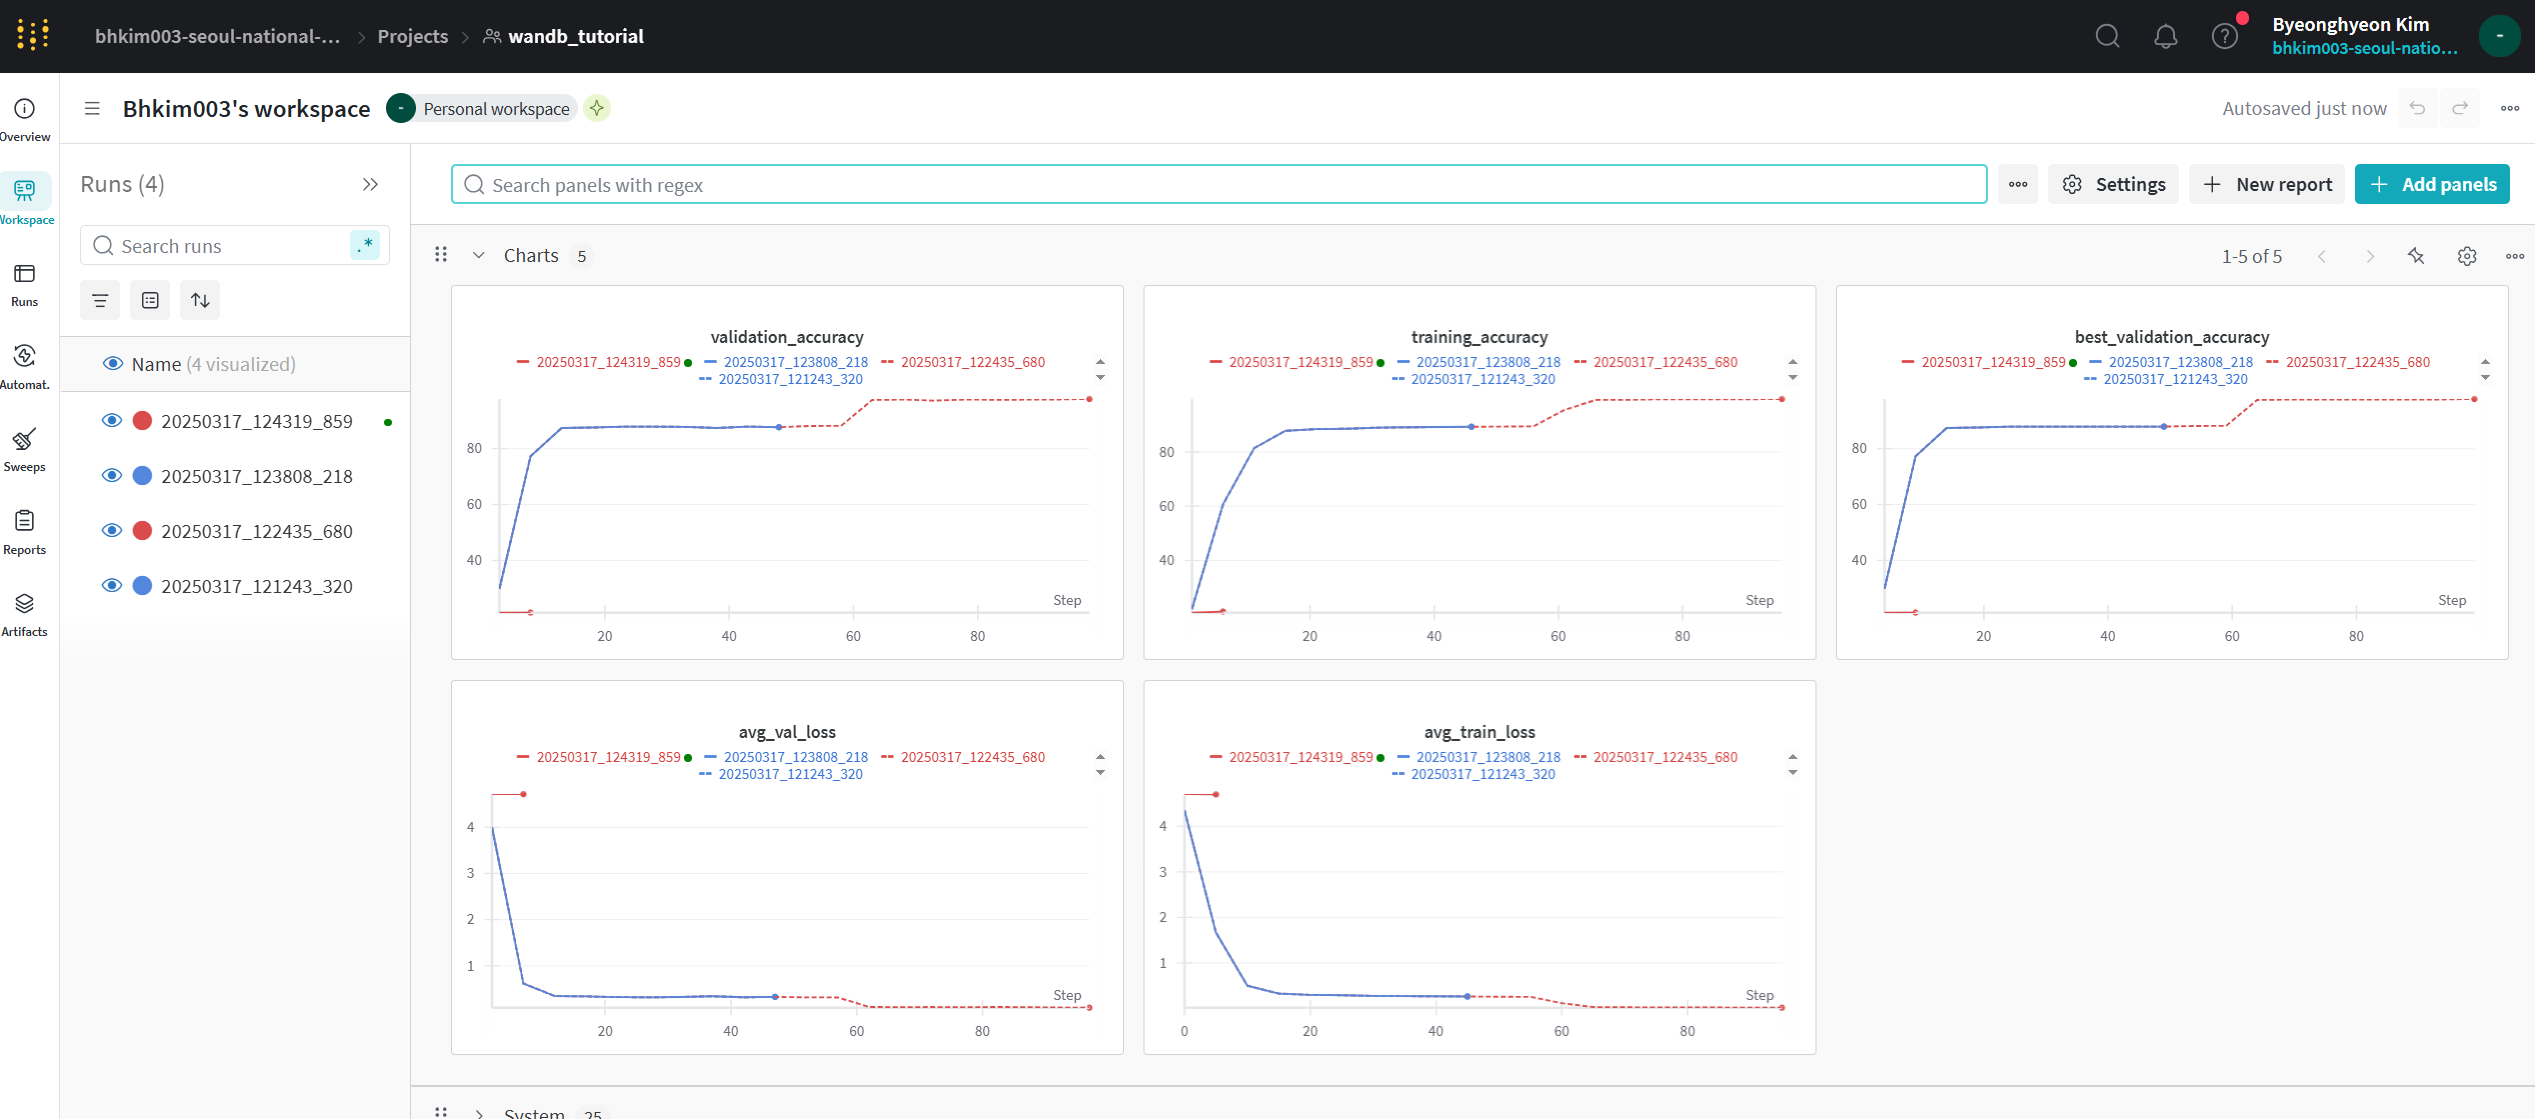

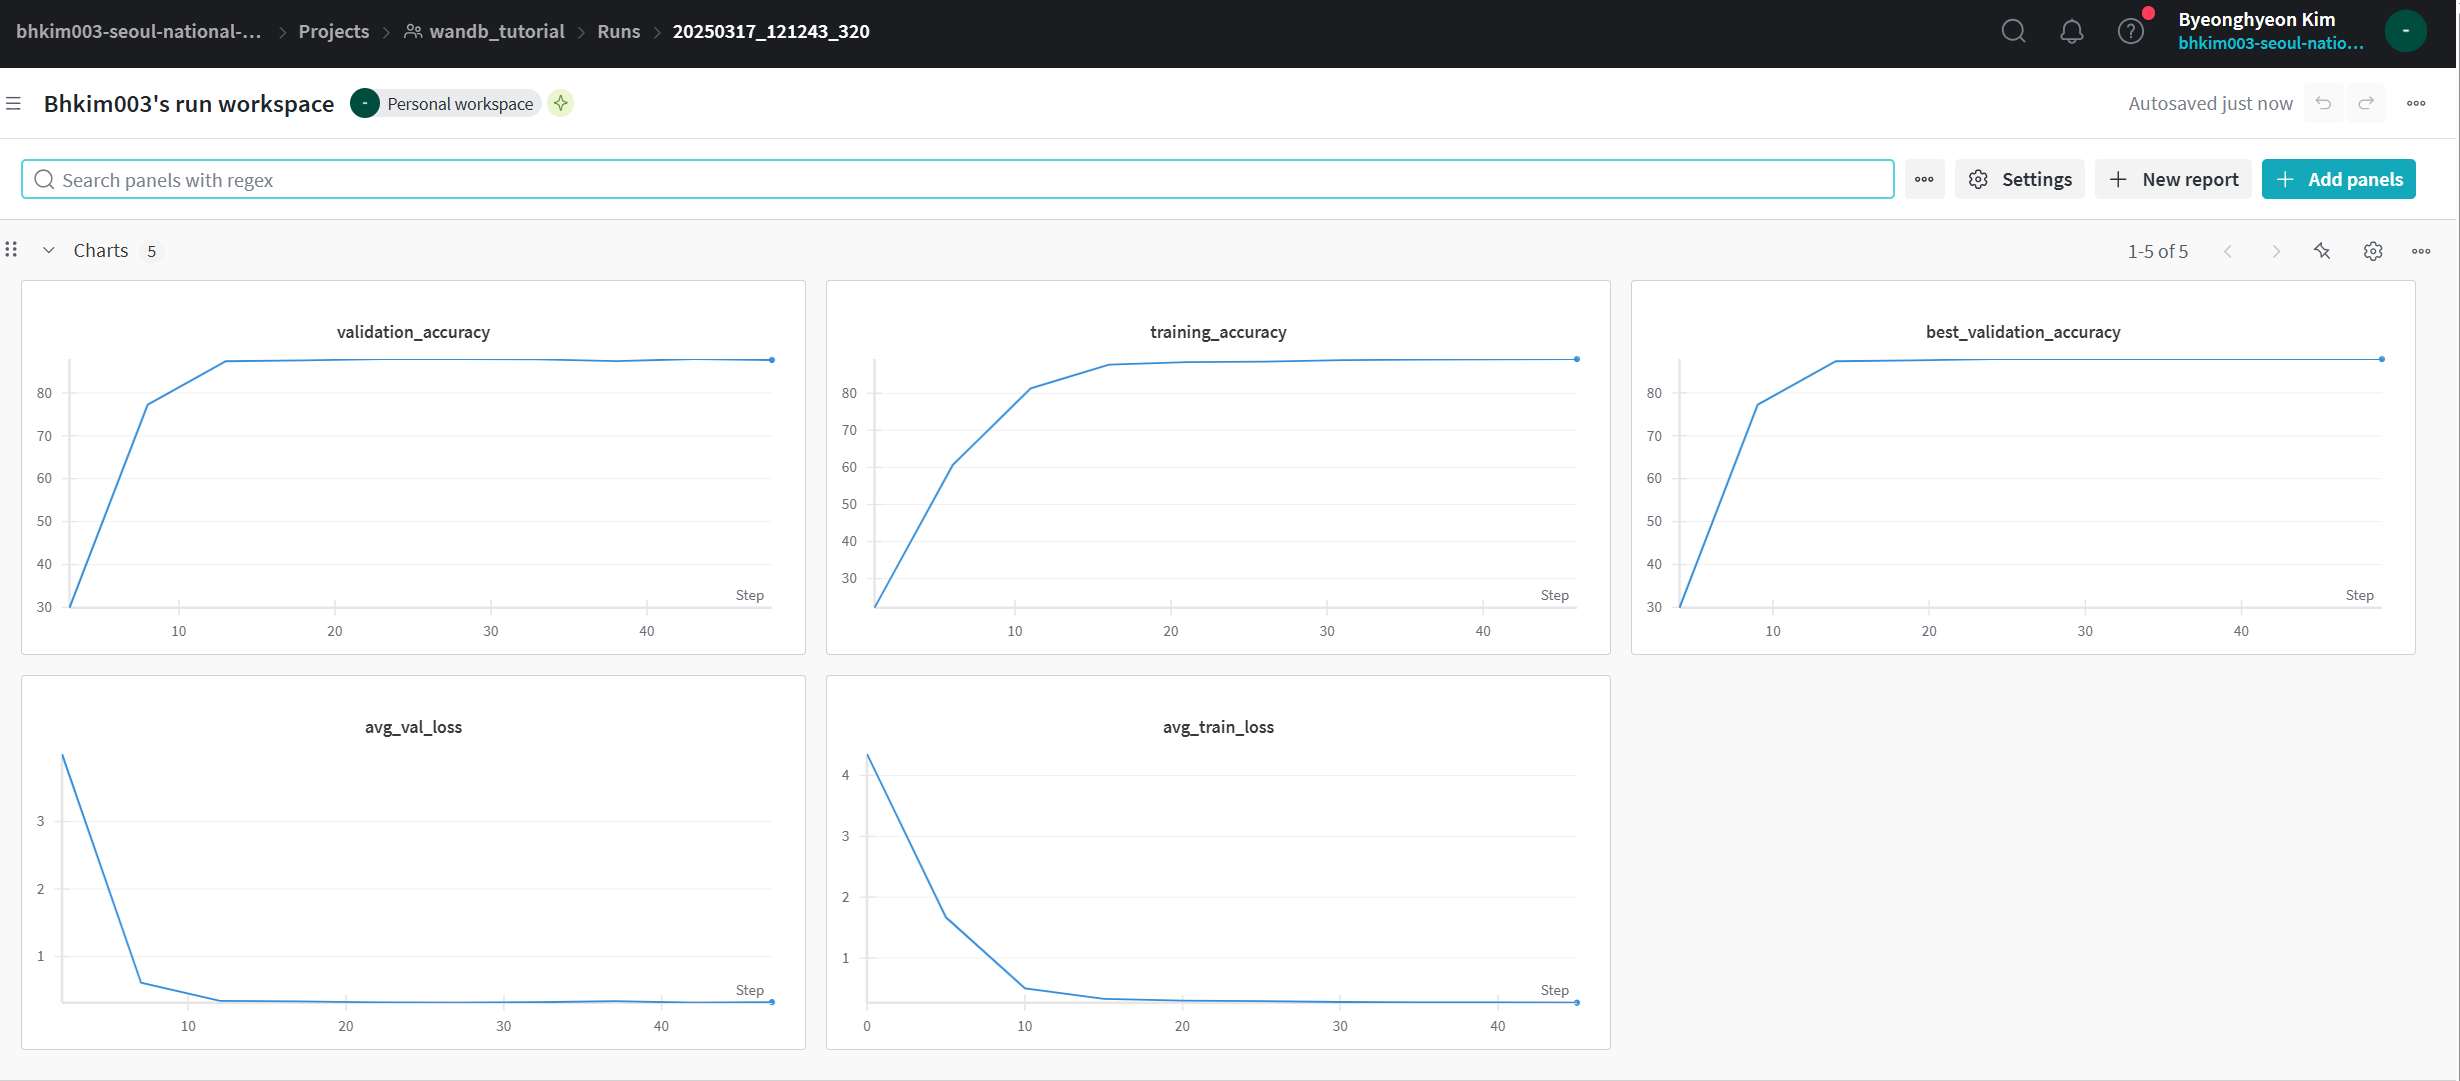